# The problem with uniform sampling in Monte Carlo integration

#### Motivation for this notebook

Lots of classes and places on the internet demo estimating the area of a circle as an introduction to Monte Carlo simulation. Few discuss efficiently estimating volumes in higher dimensions, which from my understanding, is the real selling point of Monte Carlo. The ones that do&mdash;like this blogpost and [this Wikipedia section](https://en.wikipedia.org/wiki/Variance_reduction#Crude_Monte_Carlo_simulation)&mdash;correctly argue that naive uniform sampling isn't practical and provide some reasons for that. But it can still be unclear what exactly about it can fail under the hood, how badly it can fail, and when to expect it to fail. This notebook makes these things clearer for the average reader through simple math and figures. 

## Abstract

Lots of numerical and statistical problems can be narrowed down to estimating integrals. One popular toy problem is estimating $\pi$ using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration). In demos like [this one](https://en.wikipedia.org/wiki/Monte_Carlo_integration#Example), uniform sampling is used to draw points in a square (i.e., the two-dimensional cube), count the number of points in the inscribed circle (i.e., the two-dimensional ball), and finally rescale this count to produce an estimate for $\pi$. This naive procedure is computationally scalable with respect to dimension and sample size, and its error is theoretically independent of dimension. A natural question that arises is: how well does this procedure *practically* scale? In other words, I know that my computer can sample $n$ uniform points and quickly return a Monte Carlo estimate, and that the error goes down at a rate of $n^{-1/2}$. But how many points do I need to sample to get a good estimate for higher dimensions?

The answer is: you need a lot of points. This notebook demonstrates and explains why uniform sampling scales poorly with respect to dimension for this toy problem. In short, uniformly drawn points from increasingly larger $d$-dimensional cubes will rarely ever land in increasingly smaller $d$-dimensional balls, which explodes the sampling variance. This pitfall motivates the need for more statistically efficient samplers / variance reduction techniques. 

## Intro

The Monte Carlo procedure for estimating $\pi = A/r^2$ (where $r$ is the given radius of the circle and $A$ is its area) is based on the simple fact that $A$ is an integral, so Monte Carlo integration can be used to estimate it. See [this figure and its caption](https://en.wikipedia.org/wiki/Monte_Carlo_integration#/media/File:MonteCarloIntegrationCircle.svg) for a quick rundown of the procedure. 

In general, Monte Carlo integration is an especially compelling way to estimate high-dimensional integrals. First, computing it scales well with respect to dimension. For example, independently and uniformly sampling a point in the $d$-dimensional cube just means generating $d$ random numbers, and the brunt work of computing a $\pi$ estimate from such points is taking $d$-dimensional 2-norms. Second, the variance of a Monte Carlo estimator decreases with the square root of the sample size, and can theoretically do so for any dimension. 

But this second property alone is not enough for practical success. From the [Wikipedia article](https://en.wikipedia.org/wiki/Monte_Carlo_integration):

> It is important to notice that, unlike in deterministic methods, *the estimate of the error is not a strict error bound; random sampling may not uncover all the important features of the integrand that can result in an underestimate of the error.* 

This [blogpost](https://www.johndcook.com/blog/2018/02/02/scaling-monte-carlo-integration/#:~:text=The%20idea%20behind%20Monte%20Carlo,many%20fall%20below%20the%20surface.&text=The%20error%20goes%20down%20like,of%20the%20number%20of%20points.) also discusses the discrepancy between the scaling of the estimator's theoretical variance and its actual quality. Here I'll provide some simple simulations, figures, and math to more concretely assess these properties. Note that we'll just focus on *volumes* rather than $\pi$ itself for simplicity and without loss of generality. 

## Demonstrating convergence

Let's first demonstrate that the variance of the Monte Carlo estimator scales at a rate of $n^{-1/2}$ for every dimension through convergence plots of relative errors. 

Two notes about interpreting these plots:
1. We compute relative errors of volume estimates to get close to the scale of the asymptotic error. For each plot, look for similar convergence rates rather than similar absolute values. 
2. Computing relative errors technically allows us to compare the errors of volume estimates across dimensions (y-axis of plots), but there's no use in making these comparisons. 

In [1]:
# I put all the functions used to generate statistics and plots in the
# module pi_demo to make this report look a bit cleaner
from pi_demo import *
import numpy as np
import matplotlib.pyplot as plt

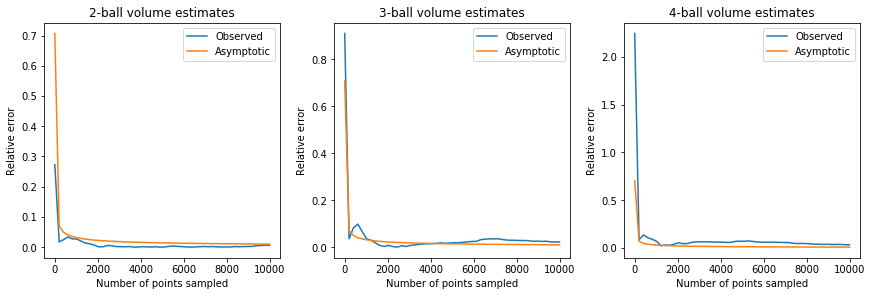

In [102]:
dimensions = range(2, 4+1)
sample_sizes = np.linspace(2, 10**4, num=50, dtype=int)

plot_errors(dimensions, sample_sizes, ncols=3, width=4, seed=0)

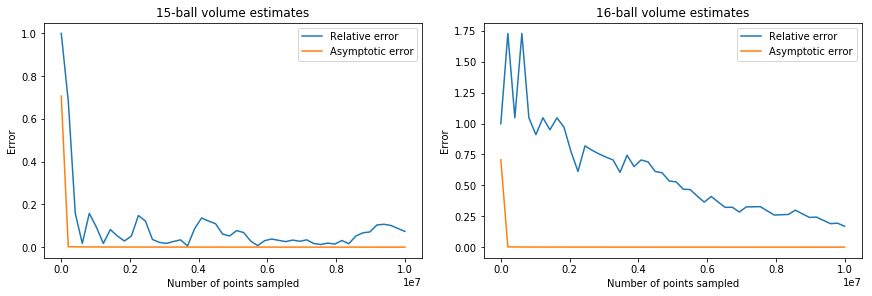

In [154]:
dimensions = range(15, 16+1)
sample_sizes = np.linspace(2, 10**7, num=50, dtype=int) # <-- up to 10M points!

plot_errors(dimensions, sample_sizes, ncols=2, width=6, seed=0)

The observed convergence rate appears to be close to the theoretical rate for every dimension. The most obvious difference between the two sets of plots above is that we had to sample up to $10^3$ times as many points to demonstrate some level of agreement between the theoretical and observed convergence rates. But even after sampling millions of points, there's  a lot of noise in the volume estimates for 15 and 16-dimensional balls. The error of the 15-ball volume estimate randomly fluctuates for computationally demanding sample sizes; sampling $15 \cdot 10$ million floating point numbers wasn't enough to get a decently robust estimate. The 15-ball volume estimator is capable of producing estimates with low relative error, but it does so in a hit-or-miss fashion. We'll more concretely explain this behavior in the next section. But for now, let's just change the seed used to generate random numbers and see how different these two plots turn out.  

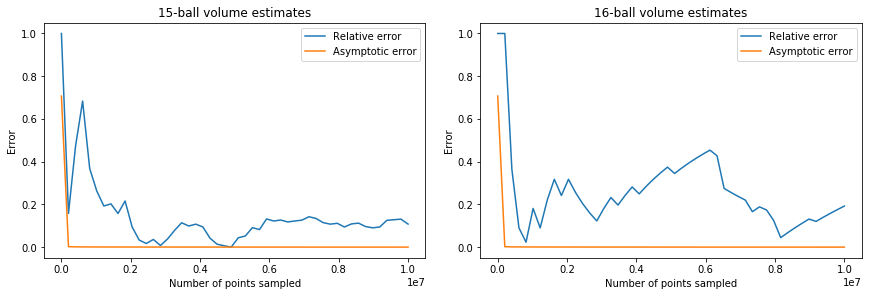

In [158]:
plot_errors(dimensions, sample_sizes, ncols=2, width=6, seed=1) # <-- just changed the seed

The plots look quite different after just changing the seed, which suggests that there's high sampling variance. 

## Demonstrating sampling variance

Let's more concretely demonstrate the degree of sampling variance by explicitly computing standard error estimates just as we'd do in any Monte Carlo simulation. 

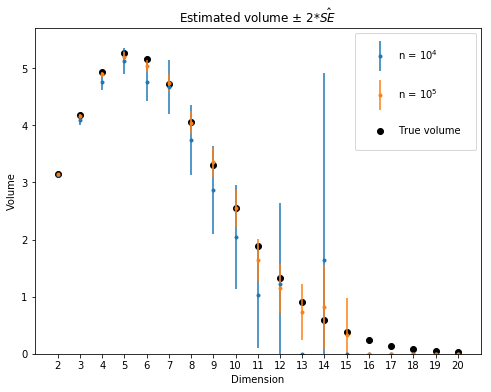

In [191]:
dimensions = range(2, 20+1)
sample_sizes = np.power(10, range(4, 5+1))

title = "Estimated volume" + " $\pm$" + " 2*$\hat{SE}$"
plot_errorbars(dimensions, sample_sizes, "est", title, seed=0)

This is the kind of plot you'd see in practice. There are two takeaways of this plot:
1. Standard error estimates (calculated using the [usual formula](https://en.wikipedia.org/wiki/Bessel%27s_correction#Formula)) are too high to have faith in the mean estimates. Even a 10-fold increase in the sample size resulted in practically noisy estimates for dimensions 12, 13, 14, and 15. 
2. For $d \geq 16$, uniform sampling from the $d$-cube never managed to draw a point from the $d$-ball, resulting in estimates with means and standard errors of 0. This results in 100% relative error, and makes those simulations wastes of computation. 

It's tempting to look at the $n = 10^4$ estimates for $3 \leq d \leq 12$ and conclude that sampling too few points results in underestimates of the true volume. But this is actually explained by the seed, not the sampling procedure itself, which we know is theoretically unbiased. In fact, changing the seed to `1` makes it seem like the sampler results in overestimates:

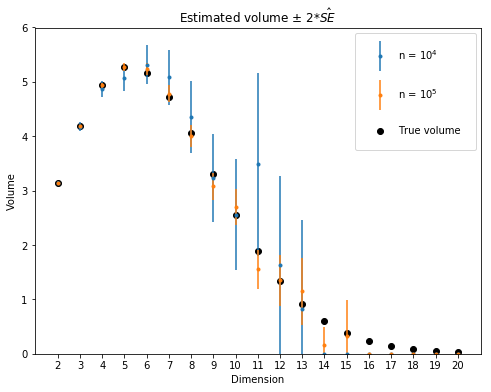

In [192]:
plot_errorbars(dimensions, sample_sizes, "est", title, seed=1) # <-- just changed the seed

In [189]:
# This explains the 0 estimates and 0 standard errors for d > 12
seed = 0 # same seed used to generate plot
for n in sample_sizes:
    print(f"n = {to_power10(n)}")
    for d in dimensions:
        is_in_ball = sample_from_cube(d, n, seed=seed)
        if np.sum(is_in_ball) == 0:
            print(f"No sampled point landed in the {d}-ball")
    print()

n = $10^4$
No sampled point landed in the 13-ball
No sampled point landed in the 15-ball
No sampled point landed in the 16-ball
No sampled point landed in the 17-ball
No sampled point landed in the 18-ball
No sampled point landed in the 19-ball
No sampled point landed in the 20-ball

n = $10^5$
No sampled point landed in the 16-ball
No sampled point landed in the 17-ball
No sampled point landed in the 18-ball
No sampled point landed in the 19-ball
No sampled point landed in the 20-ball



## Explaining the sampling variance

The theory still stands of course: observed relative error goes down at a rate similar to $n^{-1/2}$ for every dimension. But we need to sample at least 10s of millions points in order to get *robust* estimates for higher dimensions. What exactly about the problem is difficult to scale? 

Geometrically, uniformly-drawn points from increasingly larger $d$-dimensional cubes will rarely land in increasingly smaller $d$-dimensional balls. But this doesn't fully reveal why the estimator's variance scales so poorly. So let's mathematically compute it. 

Sort of following the notation in the [Monte Carlo integration Wikipedia page](https://en.wikipedia.org/wiki/Monte_Carlo_integration#Overview), let $f(\mathbf{x}_i)$ indicate whether a uniformly sampled point $\mathbf{x}_i \sim U(-1,1)^d$ is inside the unit $d$-ball, i.e.,

\begin{equation*}
f(\mathbf{x}_i) =
\begin{cases}
1 &\mbox{ if $||\mathbf{x}_i||_2 \leq 1$,} \\
0 & \mbox{otherwise}.
\end{cases}
\end{equation*}

$f(\mathbf{x}_i) \sim \text{Bernoulli}(p)$ where $p$ is the probability of the point being in the ball. Because $\mathbf{x}_i$ is uniformly sampled from the unit $d$-cube, we can compute that

\begin{align*}
p &= \text{Pr}(||\mathbf{x}_i||_2 \leq 1) \\
&= \frac{\text{Volume of ball}}{\text{Volume of cube}} \\
&= \cfrac{ \cfrac{(\pi/2)^{\left \lfloor{d/2}\right \rfloor} 2^d}{d!!} }{2^d} \\
&= \frac{(\pi/2)^{\left \lfloor{d/2}\right \rfloor}}{d!!}.
\end{align*}

The expression for the volume of the unit $d$-ball comes from [this Wikipedia page](https://en.wikipedia.org/wiki/Volume_of_an_n-ball#Alternative_forms). 

Next, the estimator for the volume of the unit $d$-ball is the volume of the cube times the proportion of $n$ points that landed in the inscribed ball, or

\begin{align*}
Q_n = 2^d \frac{N_{\text{ball}}}{n} \\
\text{where } N_{\text{ball}} = \sum_{i=1}^{n} f(\mathbf{x}_i).
\end{align*}

Because $\mathbf{x}_i$ are independent, the true standard error of this estimator is

\begin{align*}
\text{SE}(Q_n) &= \sqrt{\text{Var}(Q_n)} \\
&= \sqrt{\frac{1}{n^2} \cdot 2^{2d} \cdot \sum_{i=1}^{n} \text{Var}(f(\mathbf{x}_i))} \\
&= \sqrt{\frac{1}{n^2} \cdot 2^{2d} \cdot \sum_{i=1}^{n} p(1-p)} \\
&= \sqrt{\frac{1}{n} \cdot 2^{2d} \cdot p(1-p)}.
\end{align*}

As an aside, from this expression, we can estimate the standard error using $N_{\text{ball}}$ with

\begin{align*}
\hat{\text{SE}}(Q_n) = \sqrt{\frac{1}{n} \cdot 2^{2d} \cdot \hat{p}(1-\hat{p})} \\
\text{where } \hat{p} = N_{\text{ball}}/n
\end{align*}

instead of using the usual [unbiased sample variance estimator](https://en.wikipedia.org/wiki/Bessel%27s_correction#Formula). I'd prefer this method because $\hat{p}(1-\hat{p})$ is much faster to compute and has other nice statistical properties. 

The expression for the true standard error shows that even though $p(1-p)$ is really low in the high-dimensional case (because $p$ is low), the estimator becomes really noisy because we pay an exponential penalty for increasing the dimension. That exponential penalty is a direct consequence of naively sample from the $d$-cube. Asymptotic error ignores this huge constant term, which is practically significant. That's what the warning&mdash;"the estimate of the error is not a strict error bound"&mdash;was referring to in the Wikipedia article. The volume estimator is unbiased (i.e., has no relative error in expectation) but suffers from high variance, which explains the hit-or-miss phenomenon. 

To me, this still isn't really a satisfying answer because we don't exactly know what constitutes a "high" dimension&mdash;how did I know to pick dimensions 15 and 16 as failing examples in the plots above? Let's figure this out. 

We'll first consider $\text{Pr}(N_{\text{ball}} = 0)$ for different dimensions and sample sizes. Note that by construction, $N_{\text{ball}} \sim \text{Binomial}(n, p)$. 

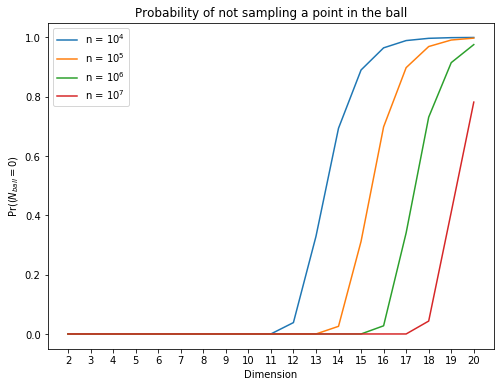

In [97]:
dimensions = range(2, 20+1)
sample_sizes = np.power(10, range(4, 7+1))

title = "Probability of not sampling a point in the ball"
labels = [f"n = {to_power10(n)}" for n in sample_sizes]
ylabel = "Pr($(N_{ball} = 0)$"
plot_across(dimensions, sample_sizes, prob_empty_ball, title, labels, ylabel)

This gives us a better idea about the actual scaling of the problem wrt dimensionality. We don't need to move very high up to nearly guarantee that the simulation never selects a point in the ball, and thus risk giving a volume estimate of 0 with 100% relative error. The estimator is theoretically unbiased for any sample size, but we practically observe the same underestimate for small sample sizes. That's what we saw in the last output in the section above. It's important not to attribute this to "bias" since the Monte Carlo estimator is theoretically unbiased for any sample size.  

Now back to the original question about variance. I find the probability plot deceiving when trying to explain the source of the volume estimator's variance. It's tempting to look at the plot and immediately conclude that the variance goes up because $\text{Pr}(N_{\text{ball}} = 0)$ goes up, and that's because $p$ goes down as the dimension goes up. This connection misses the point. We know from the expression for the true standard error that the quadratic $p(1-p)$ term is bounded above by $1/4$, so instead the unbounded exponential $2^{2d}$ term causes the variance to explode. But even if we didn't have that expression, we know that $\text{Pr}(N_{\text{ball}} = 0)$ approaches 1 when $p$ approaches 0, which actually implies that $p(1-p)$ is low! Recall that $p(1-p)$ is bounded above at $p = 1/2$, and is lower as $p$ approaches 0:

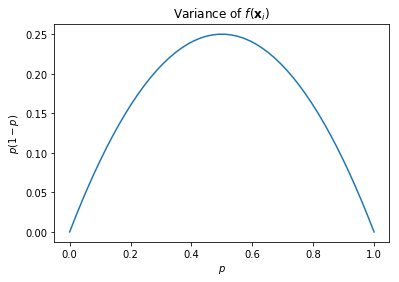

In [229]:
probs = np.linspace(0, 1)
plt.plot(probs, probs*(1-probs))
plt.xlabel("$p$")
plt.ylabel("$p(1-p)$")
plt.title("Variance of $f(\mathbf{x}_i)$");

So it's misleading to say that the hit-or-miss of the volume estimator is *caused* by $\text{Pr}(N_{\text{ball}} = 0)$ approaching 1. This probability is caused by the volume of the cube being relatively high, which causes its squared volume $2^{2d}$ to be high, which causes the variance to be high. This diagram should clear up what I mean:

<img src="diagram.png" width="800" height="50"/>

Let's now directly compute the true standard error across dimensions and sample sizes. I'll plot the true volume with errorbars to give a concrete idea of how poor the estimator can be. 

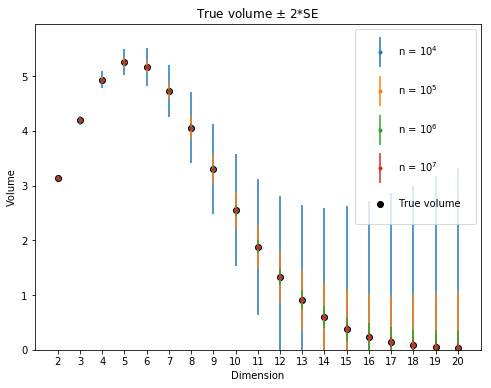

In [117]:
dimensions = range(2, 20+1)
sample_sizes = np.power(10, range(4, 7+1))

title = "True volume" + " $\pm$" + " 2*SE"
plot_errorbars(dimensions, sample_sizes, "true", title)

Here's a different visualization that separately plots the volume and the errors:

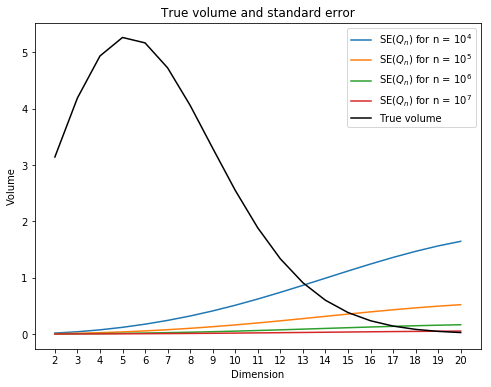

In [101]:
dimensions = range(2, 20+1)
sample_sizes = np.power(10, range(4, 7+1))

title = "True volume and standard error"
labels = [f"SE($Q_n$) for n = {to_power10(n)}" for n in sample_sizes]
ylabel = "Volume"
plot_across(dimensions, sample_sizes, true_se, title, labels, ylabel)
# add true volumes to the plot
plt.plot(dimensions, [true_volume(d) for d in dimensions], 
         color='k', label="True volume")
plt.legend();

This plot tells us that the standard error of our Monte Carlo estimator increases even as the mean estimate, the true volume, decreases! The naive procedure of uniform sampling from the $d$-cube does not result in robust estimates even for the sample sizes on the order of millions.    

Neither of these plots propertly showcase the real explosion of the estimator's dispersion though. At face value, it looks like standard error increases nearly linearly wrt dimension in that last plot. But this is only because the volume estimators are in different units across dimensions. Volumes in high dimensions converge to 0. We need to account for the different units of the volume estimator in order to compare dispersion across different dimensions. We'll compare them by the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation), as a volume being 0 is meaningful. 

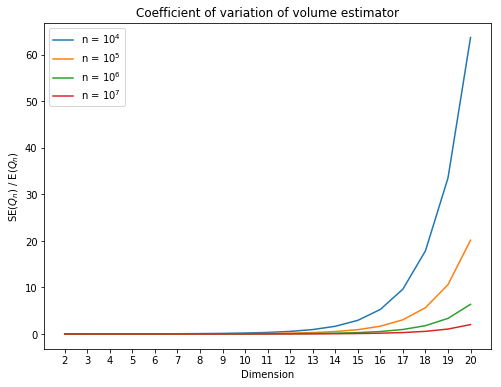

In [100]:
dimensions = range(2, 20+1)
sample_sizes = np.power(10, range(4, 7+1))

title = "Coefficient of variation of volume estimator"
labels = [f"n = {to_power10(n)}" for n in sample_sizes]
ylabel = "SE($Q_n$) / E($Q_n$)"
coef_var = lambda d, n: true_se(d, n)/true_volume(d)
plot_across(dimensions, sample_sizes, coef_var, title, labels, ylabel)

## Conclusion

The uniformly-sampled Monte Carlo estimator satisfies nice theoretical properties: it's unbiased and consistent for any dimension, and can seemingly be efficiently computed. But it becomes impractical for computing integrals where the region of interest is relatively small. In this problem, the number of points required to probably sample one in the region of interest explodes for seemingly modest increases in dimension, as does the variance of the estimator. For these reasons, uniform sampling from the $d$-cube is impractical. Solutions to this problem are variance reduction techniques such as rejection sampling and importance sampling. 